In [317]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy
import torchvision.models as models
from torchvision.datasets import ImageFolder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import random 
import os 
from skimage.segmentation import mark_boundaries
import numpy as np
import torch
from lime import lime_image
import copy
import skimage
from PIL import Image
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss

In [167]:
seed = 20202020

In [168]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),          
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20)
])
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [169]:
data_dir = 'data'
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=True)

# EDA

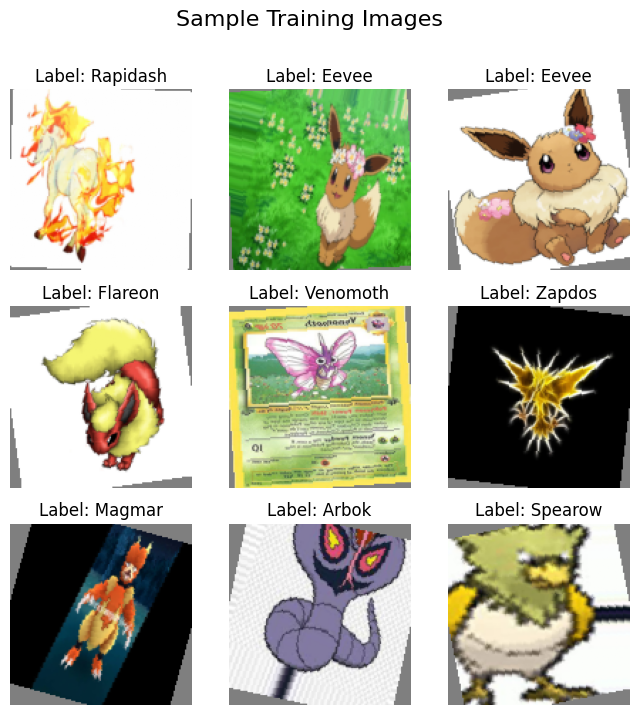

In [173]:
def imshow(img):
    img = img / 2 + 0.5  # 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(full_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('Sample Training Images', fontsize=16)

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        idx = i * 3 + j
        if idx < len(images):  
            img = images[idx]
            img = img / 2 + 0.5  
            npimg = img.numpy()
            ax.imshow(np.transpose(npimg, (1, 2, 0)))
            ax.axis('off')
            labels_names = full_dataset.classes
            ax.set_title(f'Label: {labels_names[labels[idx].item()]}')
        else:
            ax.axis('off')

plt.show()

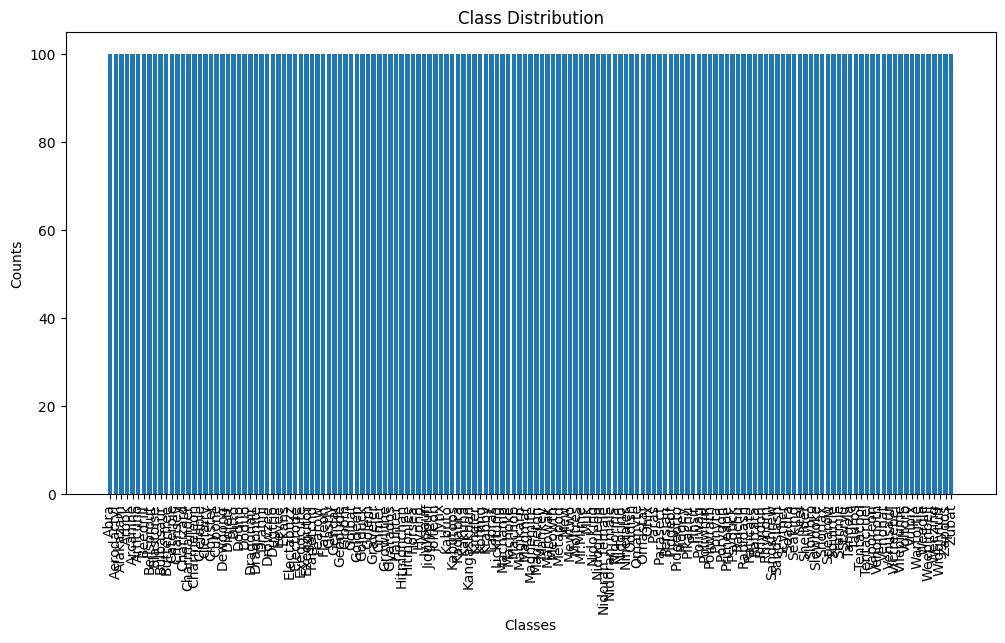

In [55]:
class_counts = {k: 0 for k in full_dataset.classes}
for _, label in full_dataset:
    class_counts[full_dataset.classes[label]] += 1
    
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Distribution')
plt.show()

In [174]:
class PokemonDataModule(L.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, train_transform=None, val_transform=None):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_transform = train_transform
        self.val_transform = val_transform

    def setup(self, stage=None):
        full_dataset = datasets.ImageFolder(root=self.data_dir, transform=self.val_transform)
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        self.train_dataset, self.val_dataset = random_split(full_dataset, [train_size, val_size])

        self.train_dataset.dataset.transform = self.train_transform

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=10, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=10, persistent_workers=True)

In [175]:
class PokemonClassifier(L.LightningModule):
    def __init__(self):
        super(PokemonClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, 3, 1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(256 * 6 * 6, 128)  # Adjusted input size
        self.fc2 = nn.Linear(128, 151)
         
        self.accuracy = Accuracy(task= "multiclass",num_classes=151)

    def forward(self, x):
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = nn.MaxPool2d(2)(x)
        
        x = nn.ReLU()(self.bn2(self.conv2(x)))
        x = nn.MaxPool2d(2)(x)
        
        x = nn.ReLU()(self.bn3(self.conv3(x)))
        x = nn.MaxPool2d(2)(x)
        
        x = nn.ReLU()(self.bn4(self.conv4(x)))
        x = nn.MaxPool2d(2)(x)
        
        x = torch.flatten(x, 1)
        
        x = self.dropout1(x)
        x = nn.ReLU()(self.fc1(x))
        
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)

In [176]:
pokemon_data = PokemonDataModule(data_dir='data', batch_size=32, train_transform=train_transform, val_transform=test_transform)
pokemon_model = PokemonClassifier()

In [177]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,          
    verbose=True,
    mode='min'           
)


checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',    
    dirpath='checkpoints', 
    filename='best-checkpoint',
    save_top_k=1,          
    mode='min'             
)

In [178]:
if torch.backends.mps.is_built():
    device = torch.device('mps')

In [179]:
device

device(type='mps')

In [180]:
pokemon_model_trainer = L.Trainer(
    max_epochs=20,
    accelerator='mps',
    callbacks=[early_stopping, checkpoint_callback],
    logger=TensorBoardLogger('lightning_logs', name='pokemon')
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [182]:
pokemon_model_trainer.fit(pokemon_model, pokemon_data)


   | Name     | Type               | Params | Mode 
---------------------------------------------------------
0  | conv1    | Conv2d             | 896    | train
1  | bn1      | BatchNorm2d        | 64     | train
2  | conv2    | Conv2d             | 18.5 K | train
3  | bn2      | BatchNorm2d        | 128    | train
4  | conv3    | Conv2d             | 73.9 K | train
5  | bn3      | BatchNorm2d        | 256    | train
6  | conv4    | Conv2d             | 295 K  | train
7  | bn4      | BatchNorm2d        | 512    | train
8  | dropout1 | Dropout            | 0      | train
9  | dropout2 | Dropout            | 0      | train
10 | fc1      | Linear             | 1.2 M  | train
11 | fc2      | Linear             | 19.5 K | train
12 | accuracy | MulticlassAccuracy | 0      | train
---------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.355     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.190 >= min_delta = 0.0. New best score: 4.787


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.148 >= min_delta = 0.0. New best score: 4.638


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 4.533


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.101 >= min_delta = 0.0. New best score: 4.432


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.093 >= min_delta = 0.0. New best score: 4.339


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 4.249


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 4.153


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 4.069


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 4.050


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 3.940


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 3.896


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 3.814


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 3.760


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 3.719


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 3.662


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 3.647


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 3.603


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 3.523


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 3.515
`Trainer.fit` stopped: `max_epochs=20` reached.


In [190]:
def unnormalize(img, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    img = img * std + mean
    return img

def evaluate_model(trainer, model, datamodule):
    trainer.validate(model, datamodule=datamodule)
    
    model.eval()
    all_preds = []
    all_labels = []
    for batch in datamodule.val_dataloader():
        images, labels = batch
        images = images.to(model.device)
        labels = labels.to(model.device)
        with torch.no_grad():
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Validation Accuracy: {accuracy}')
    
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle('Example Predictions', fontsize=16)
    for i, ax in enumerate(axes.flatten()):
        img, label = datamodule.val_dataloader().dataset[i]
        img = img.to(model.device)
        with torch.no_grad():
            output = model(img.unsqueeze(0))
            _, pred = torch.max(output, 1)
        img = img.cpu().numpy().transpose((1, 2, 0))
        img = unnormalize(img, mean, std)  
        
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f'True: {datamodule.train_dataset.dataset.classes[label]} | Pred: {datamodule.train_dataset.dataset.classes[pred.item()]}')
        ax.axis('off')
    plt.show()

Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_acc_epoch         0.25529801845550537
     val_loss_epoch         3.3143107891082764
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validation Accuracy: 0.2576158940397351


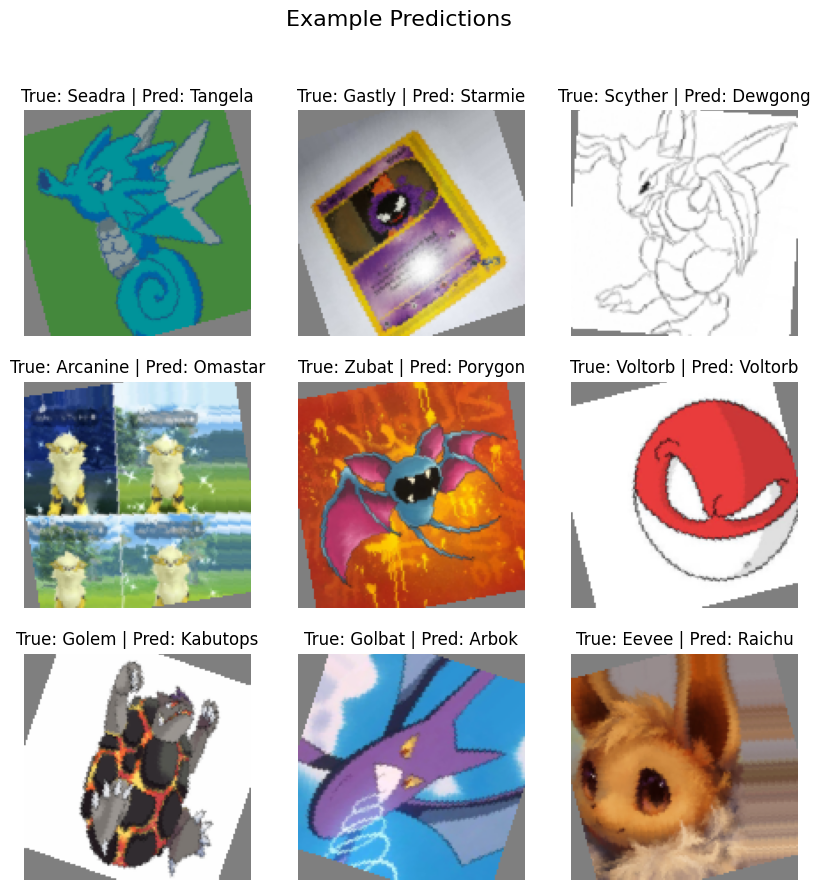

In [191]:
evaluate_model(pokemon_model_trainer, pokemon_model, pokemon_data)

In [192]:
# Load the model weights from the local file
model_path = '/Users/ofekglik/PycharmProjects/BigDataProject/resnet18-f37072fd.pth'
resnet = models.resnet18()
resnet.load_state_dict(torch.load(model_path))

# Freeze the layers
for param in resnet.parameters():
    param.requires_grad = False

class FineTuneResNet(L.LightningModule):
    def __init__(self, resnet):
        super(FineTuneResNet, self).__init__()
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        self.fc1 = nn.Linear(resnet.fc.in_features, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 151) 

        self.accuracy = Accuracy(task="multiclass", num_classes=151)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)


In [193]:
pokemon_data = PokemonDataModule(data_dir, 32, train_transform=train_transform, val_transform=test_transform)

In [194]:
fine_tune_model_v1 = FineTuneResNet(resnet)

In [195]:
early_stopping_fine_tune_v1 = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=True,
    mode='min'
)
checkpoint_callback_fine_tune_v1 = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
)

In [198]:
fine_tune_trainer = L.Trainer(
    max_epochs=20,
    accelerator='mps',
    callbacks=[early_stopping_fine_tune_v1, checkpoint_callback_fine_tune_v1]
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [199]:
fine_tune_trainer.fit(fine_tune_model_v1, pokemon_data)


  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | Sequential         | 11.2 M | train
1 | fc1      | Linear             | 262 K  | train
2 | relu     | ReLU               | 0      | train
3 | dropout  | Dropout            | 0      | train
4 | fc2      | Linear             | 77.5 K | train
5 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
340 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
46.067    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.404 >= min_delta = 0.0. New best score: 3.193


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.208 >= min_delta = 0.0. New best score: 2.985


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.148 >= min_delta = 0.0. New best score: 2.837


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.150 >= min_delta = 0.0. New best score: 2.688


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.128 >= min_delta = 0.0. New best score: 2.560


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 2.507


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 2.424


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 2.386


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 2.335


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 2.276


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 2.237


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 2.199


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 2.146


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 2.142


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 2.104


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 2.045


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 2.022


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.978


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_acc_epoch         0.6039735078811646
     val_loss_epoch         1.7135045528411865
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validation Accuracy: 0.6016556291390729


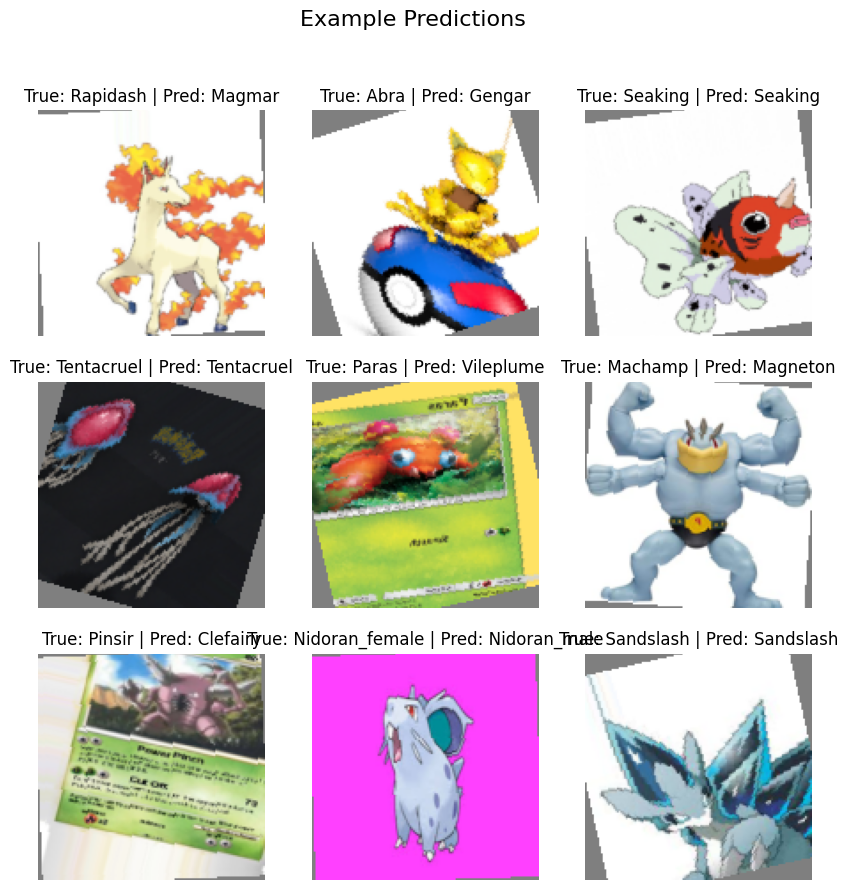

In [200]:
evaluate_model(fine_tune_trainer, fine_tune_model_v1, pokemon_data)

In [201]:
early_stopping_fine_tune_2 = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=True,
    mode='min'
)
checkpoint_callback_fine_tune_2 = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
)
fine_tune_trainer_2 = L.Trainer(
    max_epochs=20,
    accelerator='mps',
    callbacks=[early_stopping_fine_tune_2, checkpoint_callback_fine_tune_2]
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [202]:
fine_tune_model_v2 = fine_tune_model_v1

In [203]:
# Freeze the layers
for param in fine_tune_model_v1.parameters():
    param.requires_grad = True
# keep training the fine-tuned model without freezing the layers
fine_tune_trainer_2.fit(fine_tune_model_v2, pokemon_data)

/Users/ofekglik/PycharmProjects/BigDataProject/.venv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /Users/ofekglik/PycharmProjects/BigDataProject/checkpoints exists and is not empty.

  | Name     | Type               | Params | Mode
-------------------------------------------------------
0 | resnet   | Sequential         | 11.2 M | eval
1 | fc1      | Linear             | 262 K  | eval
2 | relu     | ReLU               | 0      | eval
3 | dropout  | Dropout            | 0      | eval
4 | fc2      | Linear             | 77.5 K | eval
5 | accuracy | MulticlassAccuracy | 0      | eval
-------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.067    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 1.295


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.301 >= min_delta = 0.0. New best score: 0.994


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.135 >= min_delta = 0.0. New best score: 0.859


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 0.792


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.735


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.709


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.646


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.630


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [204]:
torch.save(fine_tune_model_v2.state_dict(), 'fine_tuned_resnet_v2.pth')

In [205]:
best_model = FineTuneResNet(resnet)
best_model.load_state_dict(torch.load('fine_tuned_resnet_v2.pth'))

<All keys matched successfully>

In [206]:
best_model

FineTuneResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_acc_epoch         0.9496688842773438
     val_loss_epoch         0.20914721488952637
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validation Accuracy: 0.9447019867549669


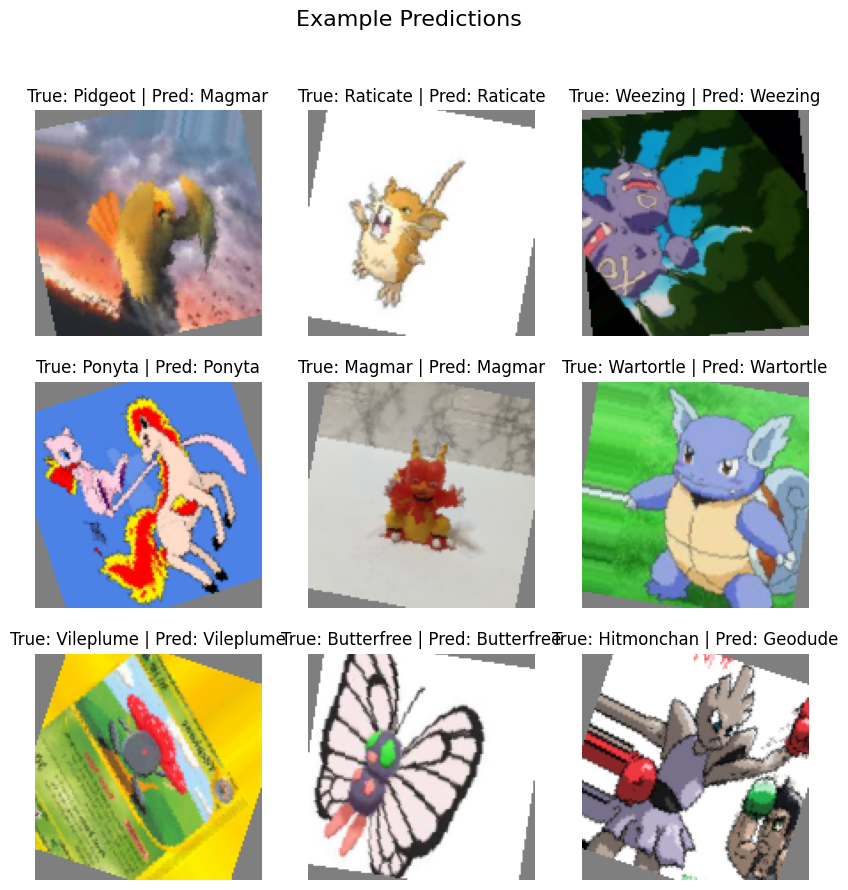

In [207]:
evaluate_model(fine_tune_trainer_2, best_model, pokemon_data)

In [208]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.model = model.resnet

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return x

feature_extractor = FeatureExtractor(fine_tune_model_v2)

dataset = ImageFolder(root=data_dir, transform=test_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=10, persistent_workers=True)

# Extract features
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            features.append(outputs.view(outputs.size(0), -1).cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

features, labels = extract_features(feature_extractor, dataloader)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=seed)



In [318]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=seed)
rf.fit(X_train, y_train)
rf_train_predictions_proba = rf.predict_proba(X_train)
rf_val_predictions_proba = rf.predict_proba(X_test)
rf_train_loss = log_loss(y_train, rf_train_predictions_proba)
rf_val_loss = log_loss(y_test, rf_val_predictions_proba)
print(f"Random Forest Train Loss: {rf_train_loss}")
print(f"Random Forest Validation Loss: {rf_val_loss}")

# Train XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=seed)
xgb.fit(X_train, y_train)
xgb_train_predictions_proba = xgb.predict_proba(X_train)
xgb_val_predictions_proba = xgb.predict_proba(X_test)
xgb_train_loss = log_loss(y_train, xgb_train_predictions_proba)
xgb_val_loss = log_loss(y_test, xgb_val_predictions_proba)
print(f"XGBoost Train Loss: {xgb_train_loss}")
print(f"XGBoost Validation Loss: {xgb_val_loss}")

# Train Extra Trees
et = ExtraTreesClassifier(n_estimators=100, random_state=seed)
et.fit(X_train, y_train)
et_train_predictions_proba = et.predict_proba(X_train)
et_val_predictions_proba = et.predict_proba(X_test)
et_train_loss = log_loss(y_train, et_train_predictions_proba)
et_val_loss = log_loss(y_test, et_val_predictions_proba)
print(f"Extra Trees Train Loss: {et_train_loss}")
print(f"Extra Trees Validation Loss: {et_val_loss}")

Random Forest Train Loss: 0.2845050931952641
Random Forest Validation Loss: 1.322937158631431
XGBoost Train Loss: 0.0060746854567896216
XGBoost Validation Loss: 0.5231085803989268
Extra Trees Train Loss: 0.00022951893396046876
Extra Trees Validation Loss: 1.318325140658193


In [319]:
rf_accuracy = accuracy_score(y_test, rf.predict(X_test))
xgb_accuracy = accuracy_score(y_test, xgb.predict(X_test))
et_accuracy = accuracy_score(y_test, et.predict(X_test))
print(f"Random Forest Validation Accuracy: {rf_accuracy}")
print(f"XGBoost Validation Accuracy: {xgb_accuracy}")
print(f"Extra Trees Validation Accuracy: {et_accuracy}")

Random Forest Validation Accuracy: 0.9350993377483444
XGBoost Validation Accuracy: 0.8721854304635761
Extra Trees Validation Accuracy: 0.9407284768211921


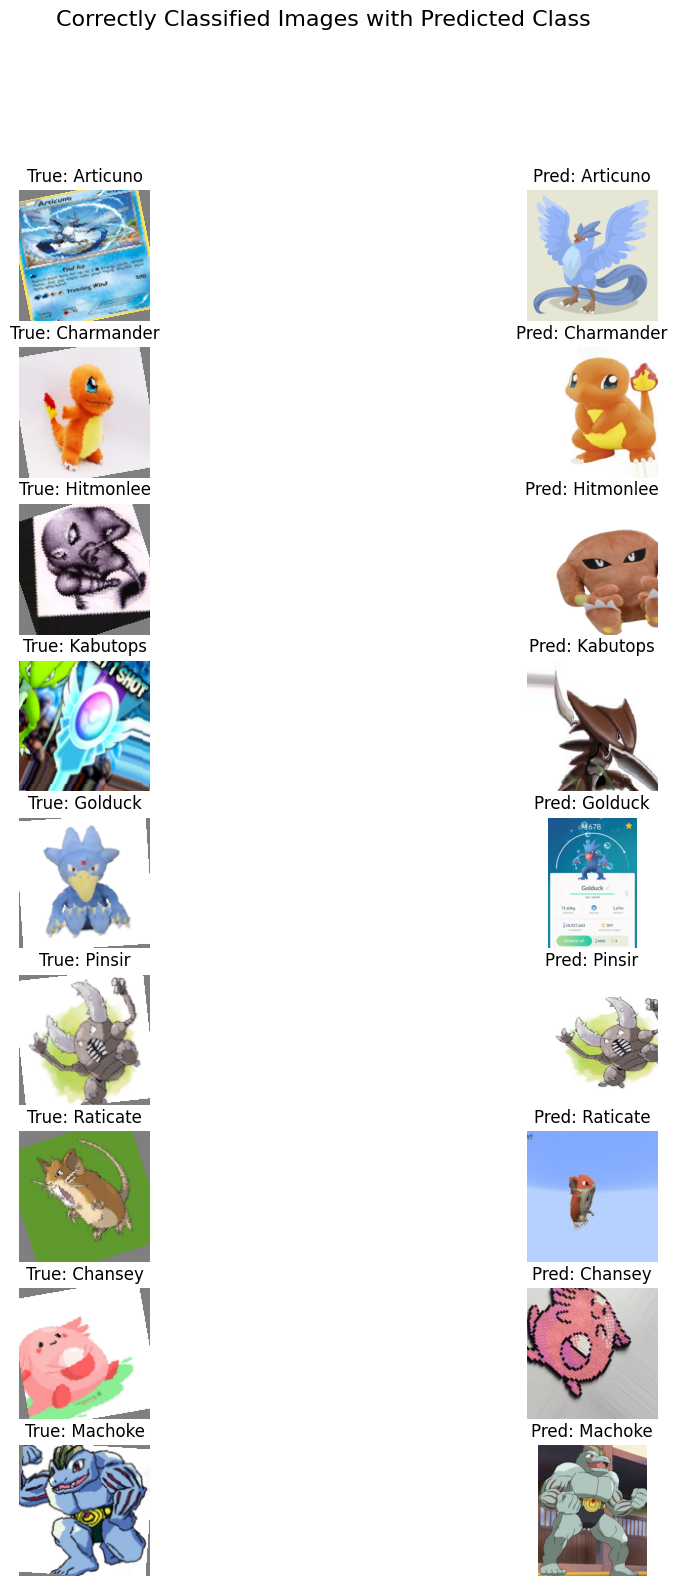

In [272]:
def plot_correct_classifications_with_predictions(model, dataset, dataloader, num_images=9):
    model.eval()

    correct_images = []
    correct_labels = []
    correct_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(model.device)
            labels = labels.to(model.device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct_mask = preds == labels
            correct_images.extend(images[correct_mask].cpu())
            correct_labels.extend(labels[correct_mask].cpu())
            correct_preds.extend(preds[correct_mask].cpu())
    
    fig, axes = plt.subplots(num_images, 2, figsize=(12, 2 * num_images))
    fig.suptitle('Correctly Classified Images with Predicted Class', fontsize=16)

    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])

    for i in range(num_images):
        if i >= len(correct_images):
            break
        
        ax = axes[i, 0]
        img = correct_images[i].numpy().transpose((1, 2, 0))
        img = (img * std + mean)  
        img = np.clip(img, 0, 1)  
        true_label = correct_labels[i].item()
        pred_label = correct_preds[i].item()
        ax.imshow(img)
        ax.set_title(f'True: {dataset.classes[true_label]}')
        ax.axis('off')
        
        pred_class_name = dataset.classes[pred_label]
        pred_class_dir = os.path.join(dataset.root, pred_class_name)
        random_img_path = os.path.join(pred_class_dir, random.choice(os.listdir(pred_class_dir)))
        random_img = Image.open(random_img_path).convert('RGB')
        
        ax = axes[i, 1]
        ax.imshow(random_img)
        ax.set_title(f'Pred: {pred_class_name}')
        ax.axis('off')
    
    plt.show()

plot_correct_classifications_with_predictions(best_model, full_dataset, full_loader)

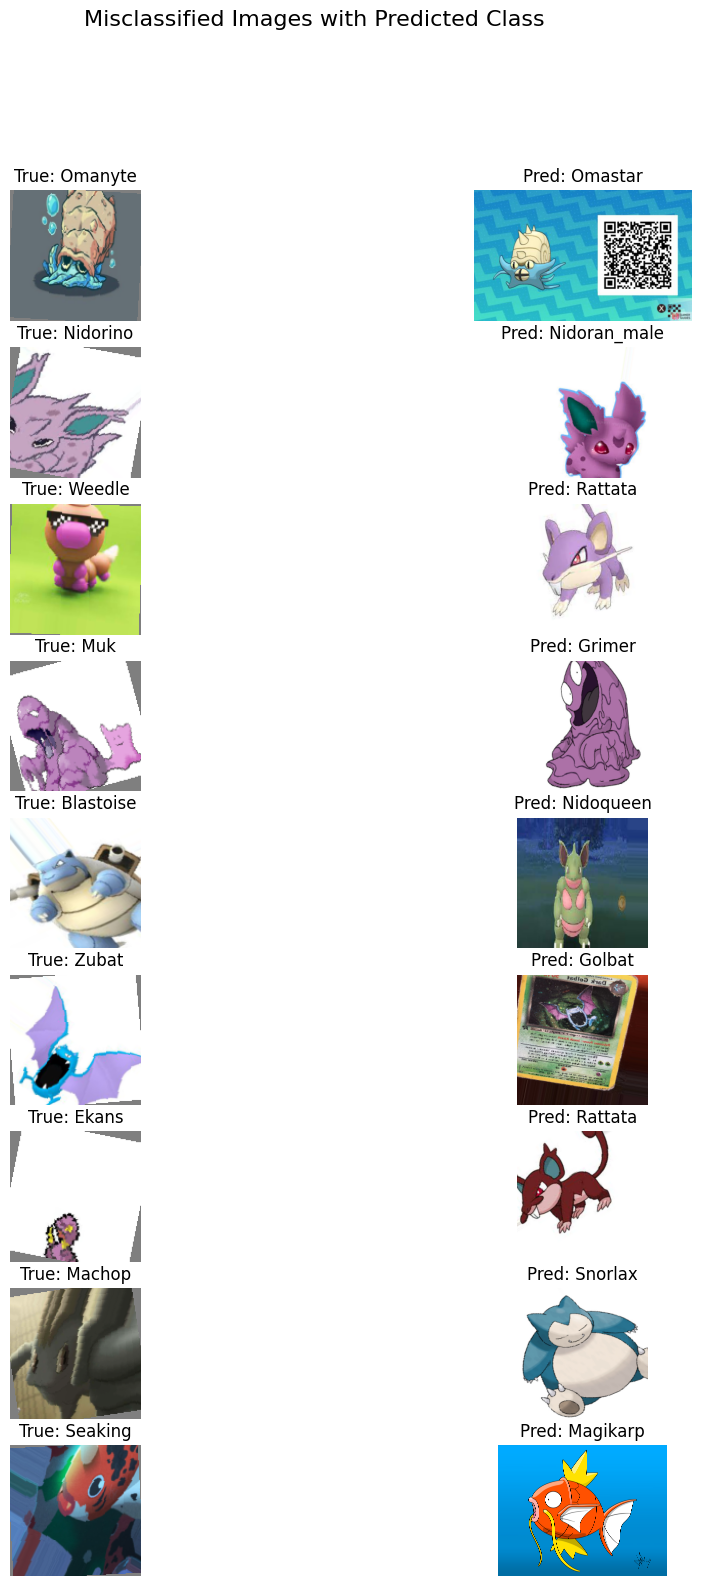

In [270]:
def plot_misclassifications_with_predictions(model, dataset, dataloader, num_images=9):
    model.eval()

    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(model.device)
            labels = labels.to(model.device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            misclassified_mask = preds != labels
            misclassified_images.extend(images[misclassified_mask].cpu())
            misclassified_labels.extend(labels[misclassified_mask].cpu())
            misclassified_preds.extend(preds[misclassified_mask].cpu())
    
    fig, axes = plt.subplots(num_images, 2, figsize=(12, 2 * num_images))
    fig.suptitle('Misclassified Images with Predicted Class', fontsize=16)

    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])

    for i in range(num_images):
        if i >= len(misclassified_images):
            break
        
        ax = axes[i, 0]
        img = misclassified_images[i].numpy().transpose((1, 2, 0))
        img = (img * std + mean) 
        img = np.clip(img, 0, 1)  
        true_label = misclassified_labels[i].item()
        pred_label = misclassified_preds[i].item()
        ax.imshow(img)
        ax.set_title(f'True: {dataset.classes[true_label]}')
        ax.axis('off')
        
        pred_class_name = dataset.classes[pred_label]
        pred_class_dir = os.path.join(dataset.root, pred_class_name)
        random_img_path = os.path.join(pred_class_dir, random.choice(os.listdir(pred_class_dir)))
        random_img = Image.open(random_img_path).convert('RGB')
        
        ax = axes[i, 1]
        ax.imshow(random_img)
        ax.set_title(f'Pred: {pred_class_name}')
        ax.axis('off')
    
    plt.show()

plot_misclassifications_with_predictions(best_model, full_dataset, full_loader)

In [235]:
for param in best_model.parameters():
    param.requires_grad = False


In [243]:
image_sample = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].


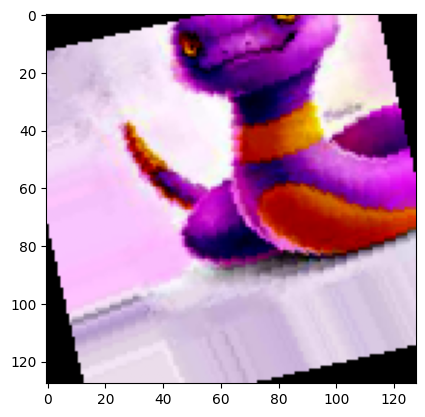

In [287]:
plt.imshow(image_sample[0][1].numpy().transpose((1, 2, 0)))

In [291]:
superpixels = skimage.segmentation.quickshift(image_sample[0][1].numpy().transpose((1, 2, 0)))

In [292]:
num_superpixels = len(np.unique(superpixels))
num_superpixels

505

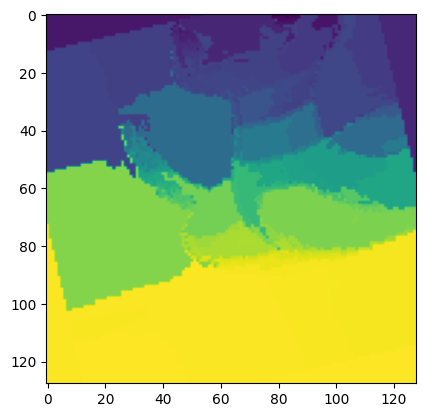

In [293]:
plt.imshow(superpixels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].


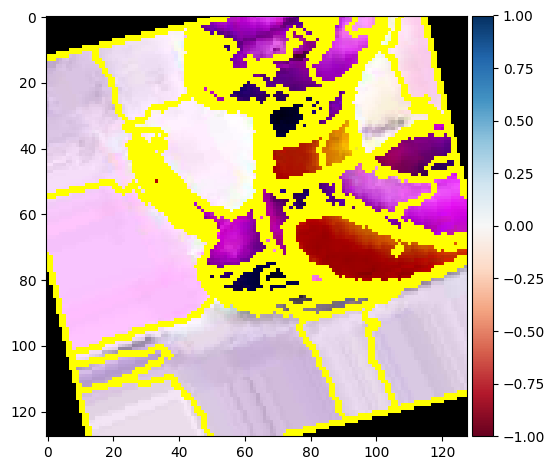

In [294]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(image_sample[0][1].numpy().transpose((1, 2, 0)), superpixels))

In [295]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] 

array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,

In [296]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

In [297]:
Xi = image_sample[0][1].numpy().transpose((1, 2, 0))

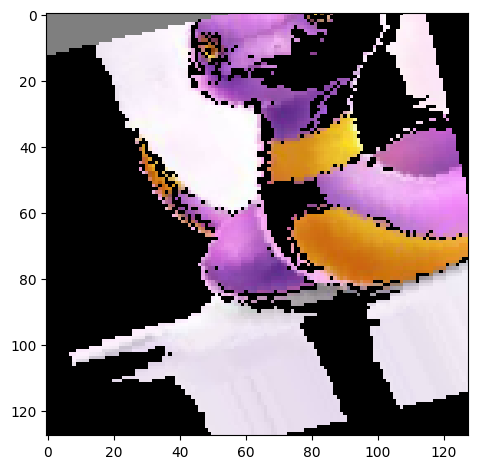

In [298]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [299]:

class LightningWrapper:
    def __init__(self, lightning_model):
        self.model = lightning_model
        self.model.eval()

    def predict(self, images):
        batch = torch.stack([torch.from_numpy(img.transpose((2, 0, 1))).float() for img in images])
        
        with torch.no_grad():
            outputs = self.model(batch)
            probs = torch.nn.functional.softmax(outputs, dim=1)
        
        return probs.cpu().numpy()

wrapped_model = LightningWrapper(best_model)

In [305]:
image1 = images[5].numpy().transpose((1, 2, 0))
image2 = images[11].numpy().transpose((1, 2, 0))
image3 = images[8].numpy().transpose((1, 2, 0))

In [306]:
def explain_image(image, wrapped_model):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image,
        wrapped_model.predict,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )
    return explanation

def plot_explain_image(image):
    explanation = explain_image(image, wrapped_model)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(image / 2 + 0.5)  
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    axes[1].set_title("Explained Image")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

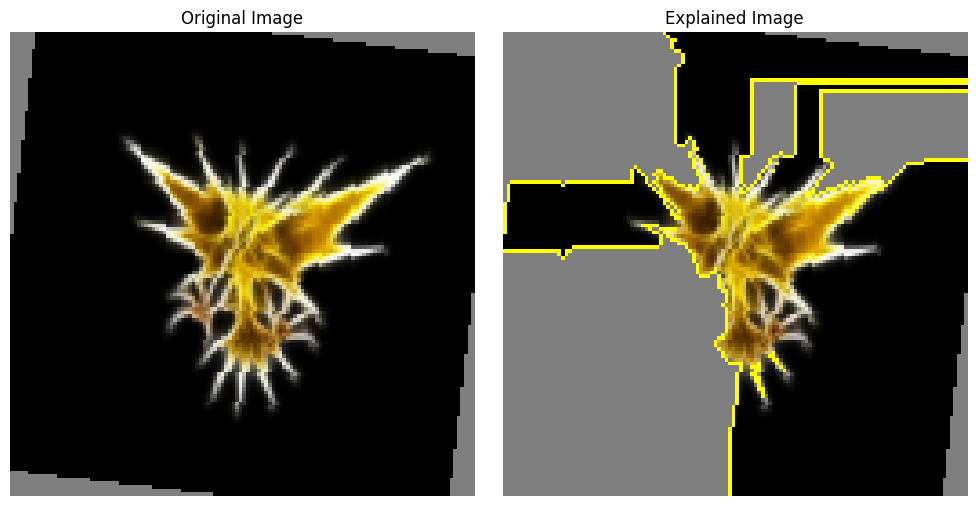

In [307]:
plot_explain_image(image1)

  0%|          | 0/1000 [00:00<?, ?it/s]

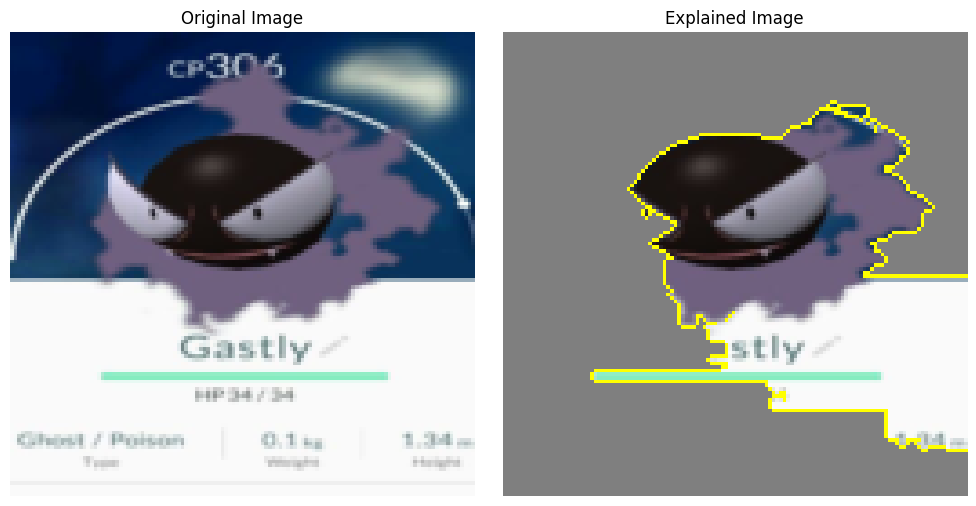

In [308]:
plot_explain_image(image2)

  0%|          | 0/1000 [00:00<?, ?it/s]

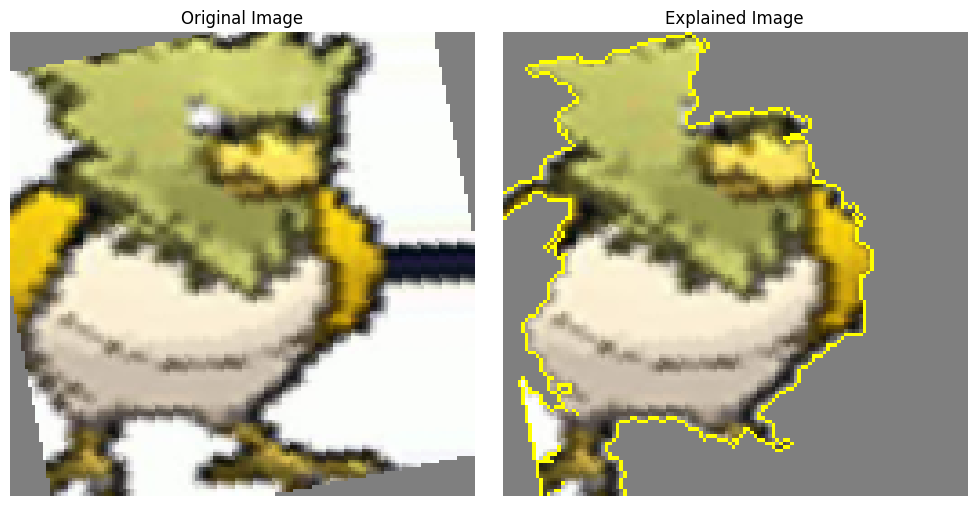

In [309]:
plot_explain_image(image3)